# Block 7 Übung 2: Visualisierung von Vitalparametern

## Bibliotheken & Konfiguration

In [1]:
packages <- c("readr", "dplyr", "ggplot2", "gridExtra")
install.packages(setdiff(packages, rownames(installed.packages())))
lapply(packages, require, character.only = TRUE)

base_url <- "https://raw.githubusercontent.com/ganslats/TMF-School-Datenanalyse-Visualisierung/master/Rohdaten/"

Lade nötiges Paket: readr

Lade nötiges Paket: dplyr


Attache Paket: ‘dplyr’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    filter, lag


Die folgenden Objekte sind maskiert von ‘package:base’:

    intersect, setdiff, setequal, union


Lade nötiges Paket: ggplot2

Lade nötiges Paket: gridExtra


Attache Paket: ‘gridExtra’


Das folgende Objekt ist maskiert ‘package:dplyr’:

    combine




[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

## MIMIC III-Basisdaten laden

In [2]:
# Patientenstammdaten laden
mimic.patients.raw <- read_csv(paste(base_url, "mimic-iii-demo/PATIENTS.csv", sep=""),
                               col_types = cols(row_id = col_integer(), subject_id = col_integer(), gender = col_character(), dob = col_datetime(format = ""), dod = col_datetime(format = ""), dod_hosp = col_datetime(format = ""), dod_ssn = col_datetime(format = ""), expire_flag = col_double()))

# Behandlungsfälle laden
mimic.admissions.raw <- read_csv(paste(base_url, "mimic-iii-demo/ADMISSIONS.csv", sep=""),
                                 col_types = cols(  row_id = col_integer(), subject_id = col_integer(), hadm_id = col_integer(), admittime = col_datetime(format = ""), dischtime = col_datetime(format = ""), deathtime = col_datetime(format = ""), admission_type = col_character(), admission_location = col_character(), discharge_location = col_character(), insurance = col_character(), language = col_character(), religion = col_character(), marital_status = col_character(), ethnicity = col_character(), edregtime = col_datetime(format = ""), edouttime = col_datetime(format = ""), diagnosis = col_character(), hospital_expire_flag = col_double(), has_chartevents_data = col_double()))

# Intensivaufenthalte laden
mimic.icustays.raw <- read_csv(paste(base_url, "mimic-iii-demo/ICUSTAYS.csv", sep=""),
                               col_types = cols(row_id = col_integer(), subject_id = col_integer(), hadm_id = col_integer(), icustay_id = col_integer(), dbsource = col_character(), first_careunit = col_character(), last_careunit = col_character(), first_wardid = col_double(), last_wardid = col_double(), intime = col_datetime(format = ""), outtime = col_datetime(format = ""), los = col_double()))


## MIMIC III-Chartevents laden

Hinweis: dieser Schritt kann wegen der Größe der Tabelle (>75MB) etwas dauern.

In [3]:
# Chartevents laden
mimic.chartevents.raw <- read_csv(paste(base_url, "mimic-iii-demo/CHARTEVENTS.csv", sep=""),
                                  col_types = cols(row_id = col_integer(), subject_id = col_integer(), hadm_id = col_integer(), icustay_id = col_integer(), itemid = col_integer(), charttime = col_datetime(format = ""), storetime = col_datetime(format = ""), cgid = col_double(), value = col_character(), valuenum = col_double(), valueuom = col_character(), warning = col_double(), error = col_double(), resultstatus = col_character(), stopped = col_character()))

### Bezeichner ergänzen

In [4]:
# Bezeichner laden
mimic.d_items.raw <- read_csv(paste(base_url, "mimic-iii-demo/D_ITEMS.csv", sep=""),
                              col_types = cols(row_id = col_integer(), itemid = col_integer(), label = col_character(), abbreviation = col_character(), dbsource = col_character(), linksto = col_character(), category = col_character(), unitname = col_character(), param_type = col_character(), conceptid = col_character()))

# Bezeichner hinzufügen
mimic.chartevents.annotated <- mimic.chartevents.raw %>%
  inner_join(mimic.d_items.raw %>% select(itemid, category, label), by = "itemid")

## Bereitgestelltes Mapping der Vitalparameter auf LOINC laden

In [5]:
map.vitalparameter <- read_delim(paste(base_url, "%C3%9Cbung/map_chartevents_vitalzeichen.csv", sep=""), delim = ";",
                                 col_types = cols(group_id = col_character(), group_name = col_character(), itemid = col_double(), label = col_character(), loinc_code_generic = col_character(), loinc_name_generic = col_character(), loinc_code_specific = col_character(), loinc_name_specific = col_character()))
head(map.vitalparameter)

group_id,group_name,itemid,label,loinc_code_generic,loinc_name_generic,loinc_code_specific,loinc_name_specific,uom
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
BP,Blood pressure,220179,Non Invasive Blood Pressure systolic,8480-6,Systolic blood pressure,76534-7,Systolic blood pressure by Noninvasive,mmHg
BP,Blood pressure,220180,Non Invasive Blood Pressure diastolic,8462-4,Diastolic blood pressure,76535-4,Diastolic blood pressure by Noninvasive,mmHg
BP,Blood pressure,51,Arterial BP [Systolic],8480-6,Systolic blood pressure,76215-3,Invasive Systolic blood pressure,mmHg
BP,Blood pressure,8368,Arterial BP [Diastolic],8462-4,Diastolic blood pressure,76213-8,Invasive Diastolic blood pressure,mmHg
BP,Blood pressure,455,NBP [Systolic],8480-6,Systolic blood pressure,76534-7,Systolic blood pressure by Noninvasive,mmHg
BP,Blood pressure,8441,NBP [Diastolic],8462-4,Diastolic blood pressure,76535-4,Diastolic blood pressure by Noninvasive,mmHg


## Vitalparameter mit Hilfe des Mappings aus den Chartevents auslesen

In [6]:
vitalparameter <- mimic.chartevents.annotated %>% 
    select(subject_id, hadm_id, icustay_id, itemid, charttime, valuenum, valueuom, warning, error) %>%
    inner_join(map.vitalparameter, by = "itemid")
head(vitalparameter)

Warning message in inner_join(., map.vitalparameter, by = "itemid"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 4 of `x` matches multiple rows in `y`.
ℹ Row 1 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


subject_id,hadm_id,icustay_id,itemid,charttime,valuenum,valueuom,warning,error,group_id,group_name,label,loinc_code_generic,loinc_name_generic,loinc_code_specific,loinc_name_specific,uom
<int>,<int>,<int>,<dbl>,<dttm>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
40124,126179,279554,220045,2130-02-04 04:32:00,94,bpm,0,0,HR,Heart rate,Heart Rate,8867-4,Heart rate,8867-4,Heart rate,bpm
40124,126179,279554,220045,2130-02-04 04:32:00,94,bpm,0,0,HR,Heart rate,HR,8867-4,Heart rate,8867-4,Heart rate,bpm
40124,126179,279554,220179,2130-02-04 04:32:00,163,mmHg,0,0,BP,Blood pressure,Non Invasive Blood Pressure systolic,8480-6,Systolic blood pressure,76534-7,Systolic blood pressure by Noninvasive,mmHg
40124,126179,279554,220180,2130-02-04 04:32:00,81,mmHg,0,0,BP,Blood pressure,Non Invasive Blood Pressure diastolic,8462-4,Diastolic blood pressure,76535-4,Diastolic blood pressure by Noninvasive,mmHg
40124,126179,279554,220179,2130-02-04 05:00:00,128,mmHg,0,0,BP,Blood pressure,Non Invasive Blood Pressure systolic,8480-6,Systolic blood pressure,76534-7,Systolic blood pressure by Noninvasive,mmHg
40124,126179,279554,220180,2130-02-04 05:00:00,62,mmHg,0,0,BP,Blood pressure,Non Invasive Blood Pressure diastolic,8462-4,Diastolic blood pressure,76535-4,Diastolic blood pressure by Noninvasive,mmHg


## Aufgabe: Visualisieren Sie Vitalparameterverläufe einzelner Intensiv-Aufenthalte mit ggplot!

Hier können Sie das Wissen aus dem Abschnitt 4, Demo 2 (Daten abfragen mit Tidyverse) und dem Abschnitt 6, Demo 1 (Daten visualisieren, Diagramme) anwenden.
* zugehörige Notebooks: [teil-4-demo-02-abfragen-tidyverse.ipynb](https://github.com/ganslats/TMF-School-2021-Block-7/blob/main/Notebooks/teil-4-demo-02-abfragen-tidyverse.ipynb), [teil-6-demo-01-visualisieren-diagramme.ipynb](https://github.com/ganslats/TMF-School-2021-Block-7/blob/main/Notebooks/teil-6-demo-01-visualisieren-diagramme.ipynb)
* nutzen Sie gerne auch das [ggplot2-Cheat Sheet von RStudio](https://github.com/rstudio/cheatsheets/raw/master/data-visualization-2.1.pdf)

Filtern Sie den oben generierten Vitalparameter-Datensatz auf die Inhalte jeweils eines der folgenden Intensivaufenthalte mit Hilfe der Spalte `icustay_id`:
* 249805
* 276601
* weitere `ìcustay_id`-Nummern können Sie aus dem Tibble `mimic.icustays.raw` entnehmen und sich dabei z.B. an der Länge des Aufenthalts in der Spalte `los` (length of stay) orientieren

Tipps zu ggplot:
* überlegen Sie, welche Variablen Sie für die x- und y-Achsen in der `aes()`-Funktion einsetzen möchten
* Sie können mehrere Variablen im gleichen Diagramm unterscheiden, indem Sie z.B. die Farbe (`fill`-Attribut) über die Variable setzen
* Sie können Variablen auf mehrere (Teil-)Diagramme aufteilen, indem Sie die `facet_wrap()`-Funktion benutzen
* alternativ können Sie auch mehrere Plots getrennt erstellen und über die `grid.arrange()`-Funktion des Pakets gridExtra explizit layouten
* mit der `ylim(von, bis)`-Funktion können Sie festlegen welchen Wertebereich die Y-Skala abdecken soll
* mit der `ylab(titel)`-Funktion können Sie den Titel der y-Achase festlegen

### Stellen Sie alle Vitalparameter in einer gemeinsamen Grafik dar!

Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


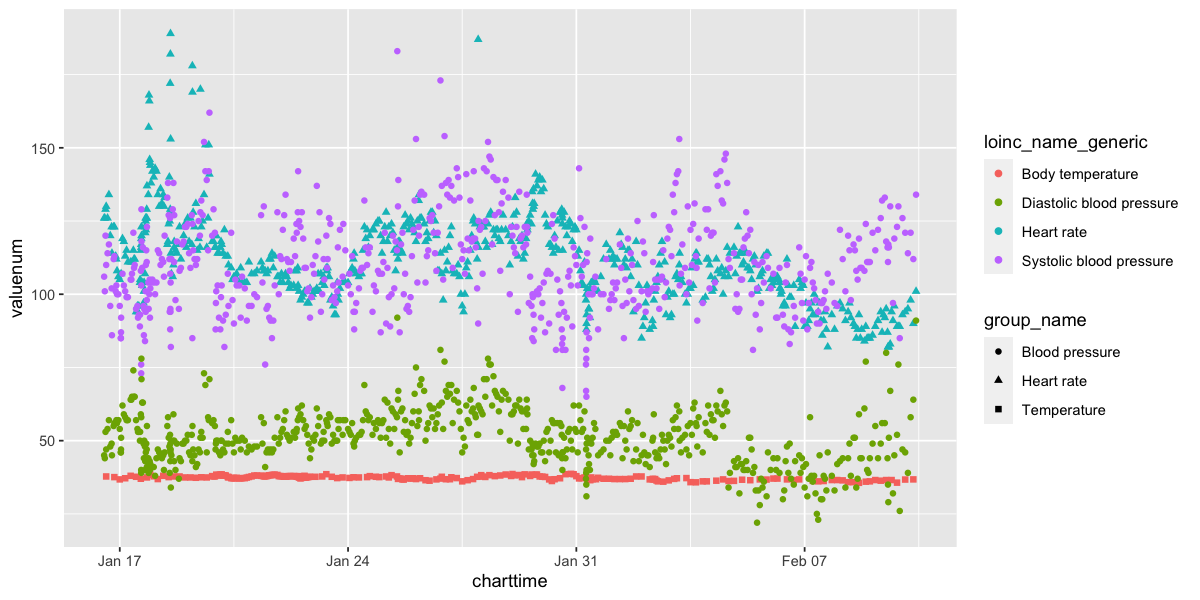

In [7]:
# Visualisierung der Vitalparameterverläufe eines Intensivaufenthalts in einer gemeinsamen Grafik
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(data = vitalparameter %>% filter(icustay_id == 223177), aes(x = charttime, y = valuenum, shape = group_name, color = loinc_name_generic)) +
    geom_point()

### Stellen Sie Blutdruck, Puls & Temperatur in jeweils getrennten Grafiken dar!

Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


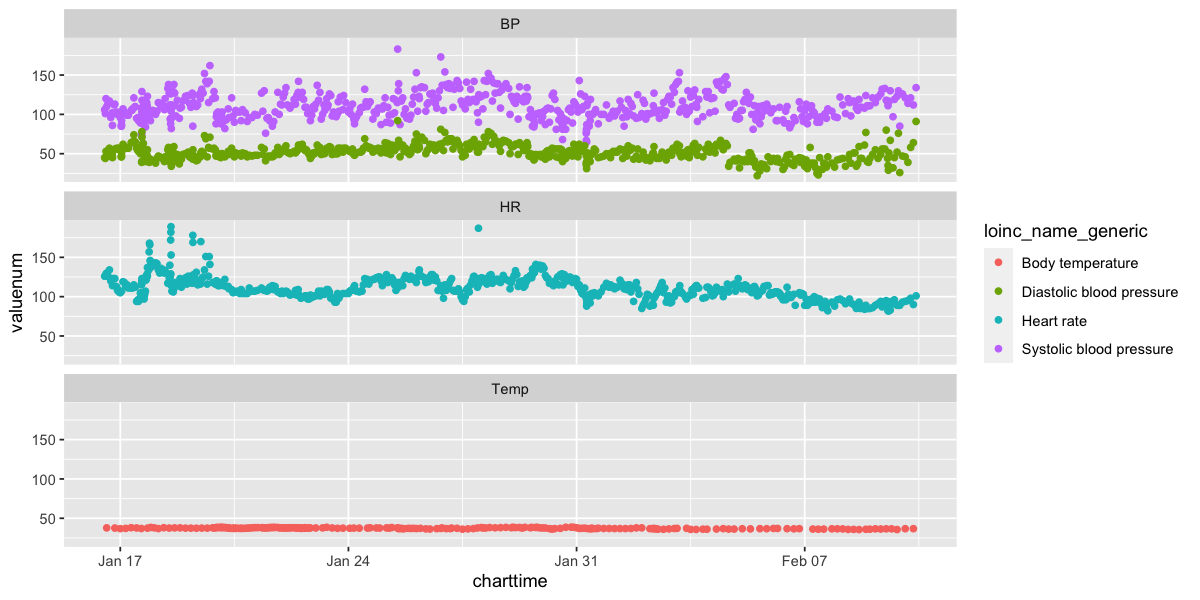

In [8]:
# Aufteilung der Parameter in mehrere Grafiken
# Option 1: Nutzung von facet_wrap()
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(data = vitalparameter %>% filter(icustay_id == 223177), aes(x = charttime, y = valuenum, color = loinc_name_generic)) +
    geom_point() +
    facet_wrap(~group_id, ncol = 1)

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


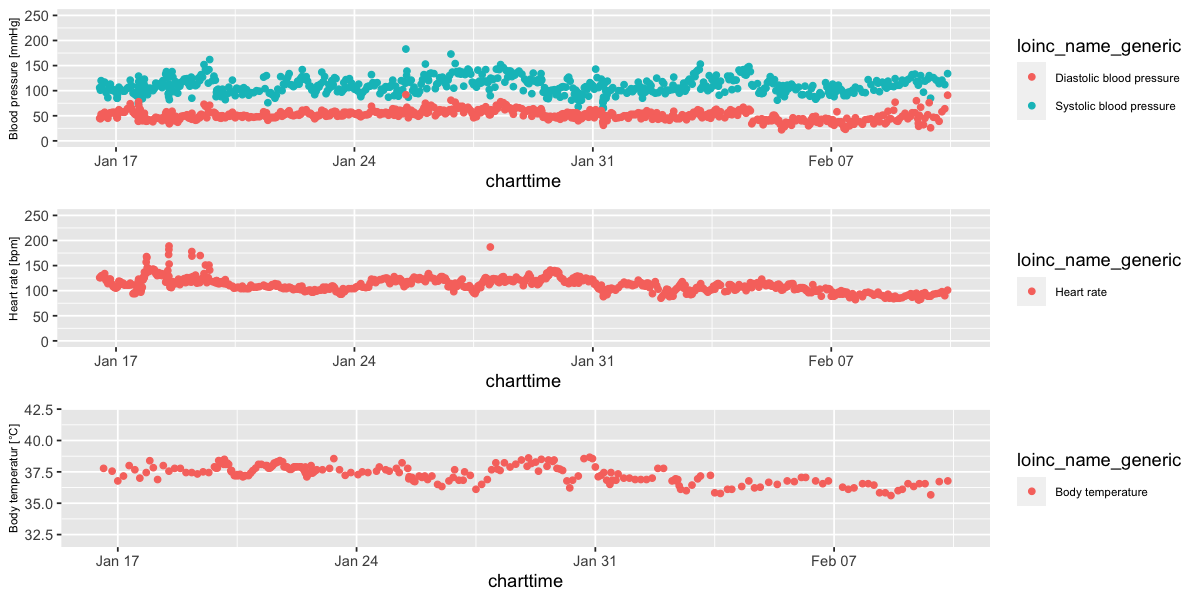

In [9]:
# Aufteilung der Parameter in mehrere Grafiken
# Option 2: Nutzung von Einzelplots, die anschließend layouted werden
# Vorteil: Größe & Skalen können individuell eingestellt werden
options(repr.plot.width = 10, repr.plot.height = 5)
plot.rr   <- ggplot(data = vitalparameter %>% filter(icustay_id == 223177, group_id == "BP"),   aes(x = charttime, y = valuenum, color = loinc_name_generic)) +
    geom_point() +
    ylim(0, 250) +
    ylab("Blood pressure [mmHg]") +
    theme(legend.text = element_text(size = 7),
          axis.title.y = element_text(size = 7))
plot.hr   <- ggplot(data = vitalparameter %>% filter(icustay_id == 223177, group_id == "HR"),   aes(x = charttime, y = valuenum, color = loinc_name_generic)) +
    geom_point() +
    ylim(0, 250) +
    ylab("Heart rate [bpm]") +
    theme(legend.text = element_text(size = 7),
          axis.title.y = element_text(size = 7))
plot.temp <- ggplot(data = vitalparameter %>% filter(icustay_id == 223177, group_id == "Temp"), aes(x = charttime, y = valuenum, color = loinc_name_generic)) +
    geom_point() +
    ylim(32, 42) +
    ylab("Body temperatur [°C]") +
    theme(legend.text = element_text(size = 7),
          axis.title.y = element_text(size = 7))

# grid.arrange aus dem Paket gridExtra erlaubt es Grafiken explizit auf die Felder einer Matrix zu setzen
# im Attribut layout_matrix können werden die vorher angegebenen Plots der Reihe nach in die jeweiligen Zellen der Matrix gesetzt
grid.arrange(plot.rr, plot.hr, plot.temp,
             layout_matrix = rbind(c(1), c(2), c(3)))